In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [2]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.PReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.PReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, logvar

def vae_loss(reconstructed_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(reconstructed_x, x)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

In [3]:
# 设置参数
input_dim = 400
hidden_dim = 256
latent_dim = 64
batch_size = 64
epochs = 300
learning_rate = 1e-3

In [4]:
# 加载数据
data = np.load("/Users/dongtianchi/Documents/GIT/SpectralReconstruction/ComputationalSpectrometers/Deeplearning/DATA/data_spectrum.npy", allow_pickle=True)  
X_train, X_test = train_test_split(data.T, test_size=0.2)
#mm = MinMaxScaler()
#data_train = mm.fit_transform(X_train)
#data_test = mm.fit_transform(X_test)

data_train = X_train
data_test = X_test


In [8]:
X_train.shape

(1195, 400)

In [6]:
data_test.shape

(299, 400)

In [9]:
data_train = data_train.astype(np.float32)
data_test = data_test.astype(np.float32)

In [10]:
train_loader = DataLoader(TensorDataset(torch.tensor(data_train, dtype=torch.float32)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.tensor(data_test, dtype=torch.float32)), batch_size=batch_size)

# 创建模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

In [11]:
# 训练
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for batch in train_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        reconstructed_x, mu, logvar = vae(x)
        loss = vae_loss(reconstructed_x, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    train_loss /= len(train_loader)
    print(f'Epoch: {epoch + 1}, Train Loss: {train_loss}')



Epoch: 1, Train Loss: 1.013686256973367
Epoch: 2, Train Loss: 0.08767991689474959
Epoch: 3, Train Loss: 0.01745842323687516
Epoch: 4, Train Loss: 0.006007564180579625
Epoch: 5, Train Loss: 0.0032672251721746043
Epoch: 6, Train Loss: 0.0022662247126725944
Epoch: 7, Train Loss: 0.0016612933311415347
Epoch: 8, Train Loss: 0.0013493331038932268
Epoch: 9, Train Loss: 0.001109548023362693
Epoch: 10, Train Loss: 0.0009167434488374152
Epoch: 11, Train Loss: 0.0007716842933165792
Epoch: 12, Train Loss: 0.0006469067899926909
Epoch: 13, Train Loss: 0.0005603577255418426
Epoch: 14, Train Loss: 0.0004981664119680461
Epoch: 15, Train Loss: 0.0004427847590321969
Epoch: 16, Train Loss: 0.00038476249717764164
Epoch: 17, Train Loss: 0.0003462292875874003
Epoch: 18, Train Loss: 0.0003043649217273158
Epoch: 19, Train Loss: 0.0002819174467157082
Epoch: 20, Train Loss: 0.0002607569377256655
Epoch: 21, Train Loss: 0.0002347016530907958
Epoch: 22, Train Loss: 0.00021523943455816296
Epoch: 23, Train Loss: 0.00

In [12]:
# 测试
vae.eval()

dataset = []

test_loss = 0
with torch.no_grad():
    for batch in test_loader:
        x = batch[0].to(device)
        reconstructed_x, mu, logvar = vae(x)
        dataset.append(reconstructed_x)
        loss = vae_loss(reconstructed_x, x, mu, logvar)
        test_loss += loss.item()
    
test_loss /= len(test_loader)
print(f'Epoch: {epoch + 1}, Test Loss: {test_loss}')

Epoch: 300, Test Loss: 0.00024069183273240925


In [13]:
# 创建一个列表来存储重建的测试数据
reconstructed_test_data = []

# 遍历测试数据加载器
for batch in test_loader:
    x = batch[0]
    
    # 使用训练好的 VAE 对批量数据进行重建
    with torch.no_grad():
        reconstructed_batch, _, _ = vae(x)
    
    # 将重建的批次添加到列表中
    reconstructed_test_data.append(reconstructed_batch.detach().numpy())

# 将列表转换为 NumPy 数组
reconstructed_test_data = np.concatenate(reconstructed_test_data, axis=0)
print("Reconstructed test data shape:", reconstructed_test_data.shape)


Reconstructed test data shape: (299, 400)


In [14]:
#test_result = mm.inverse_transform(reconstructed_test_data).T
test_result = reconstructed_test_data.T
test_result.shape

(400, 299)

In [15]:
original = X_test.T
original.shape

(400, 299)

In [16]:
import matplotlib.pyplot as plt
import os
wavelengths = np.arange(380, 780, 1)

def Plot(light, save_path=None):
    # 创建一个包含三个子图的图像
    fig, axs = plt.subplots(3, 1)
    s = original[:,light]
    r = test_result[:,light]

    # 绘制真实光谱图
    axs[0].plot(wavelengths, s, label='True Spectrum')
    axs[0].set_xlabel('Wavelength (nm)')
    axs[0].set_ylabel('Intensity')
    axs[0].set_title('True Spectrum vs Reconstructed Spectrum')
    axs[0].legend()

        # 绘制重建光谱图
    axs[1].plot(wavelengths, r, label='Reconstructed Spectrum')
    axs[1].set_xlabel('Wavelength (nm)')
    axs[1].set_ylabel('Intensity')
    axs[1].legend()

    # 绘制重建光谱和真实光谱叠加的图
    axs[2].plot(wavelengths, s, label='True Spectrum')
    axs[2].plot(wavelengths, r, label='Reconstructed Spectrum')
    axs[2].set_xlabel('Wavelength (nm)')
    axs[2].set_ylabel('Intensity')
    axs[2].legend()


    plt.tight_layout()
    plt.show()

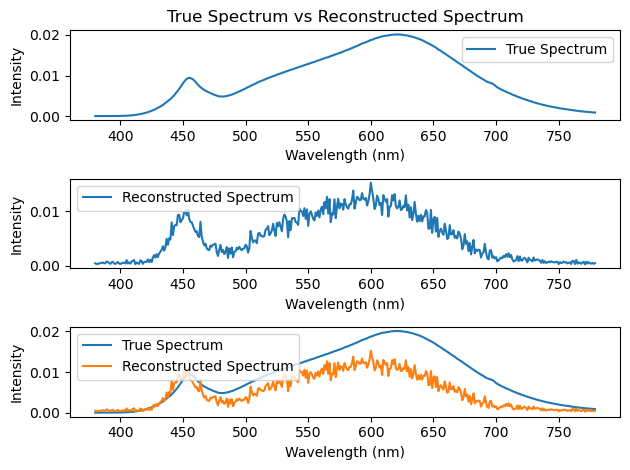

In [17]:
Plot(120)